In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import datatable as dt
import xgboost as xgb
import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv('data_clean.csv', parse_dates = ['FECHA_DESPACHO'])

In [3]:
# drop unnecessary features
df.drop(['MUNICIPIO_ORIGEN_RUTA','MUNICIPIO_DESTINO_RUTA', 'PASAJEROS'], axis=1, inplace=True)
df.rename(columns={'PASAJEROS_CLEAN':'PASAJEROS'}, inplace=True)
df.drop(377120,inplace=True)

In [4]:
# Function to run XGBoost model, obtain results of prefrormance and save model .pkl in root folder

def XGBoost_terminals(name_ter):
    df_terminal =df[df['TERMINAL'] ==name_ter]

    # grouped df by key features

    grouped_data=df_terminal.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                       'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
    grouped_data = grouped_data.rename(columns={'sum':'PASAJEROS'})

    #Create new features of date-time for the model

    dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                 '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                 '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                 '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                 '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

    grouped_data['FESTIVOS'] =   grouped_data['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

    grouped_data['dayofweek'] =  grouped_data['FECHA_DESPACHO'].dt.dayofweek
    grouped_data['quarter'] =    grouped_data['FECHA_DESPACHO'].dt.quarter
    grouped_data['month'] =      grouped_data['FECHA_DESPACHO'].dt.month
    grouped_data['year'] =       grouped_data['FECHA_DESPACHO'].dt.year
    grouped_data['dayofyear'] =  grouped_data['FECHA_DESPACHO'].dt.dayofyear
    grouped_data['dayofmonth'] = grouped_data['FECHA_DESPACHO'].dt.day
    grouped_data['weekofyear'] = grouped_data['FECHA_DESPACHO'].dt.weekofyear

    # Create key feature for dates whit mobility restriction

    grouped_data["restriccion"] = np.where(grouped_data['FECHA_DESPACHO']<='2020-03-26',3,
    np.where((grouped_data['FECHA_DESPACHO'] > '2020-03-26')&(grouped_data['FECHA_DESPACHO'] <='2020-08-31'),0,
    np.where((grouped_data['FECHA_DESPACHO'] >='2020-09-01')&(grouped_data['FECHA_DESPACHO'] <= '2021-02-28'),1,
    np.where((grouped_data['FECHA_DESPACHO'] >='2021-03-01')&(grouped_data['FECHA_DESPACHO'] <= '2021-11-30'),2,
    3))))

    # Create new feature route

    grouped_data["Depto_Municipio"]=grouped_data['DEPARTAMENTO_DESTINO']+' '+grouped_data['MUNICIPIO_DESTINO']
    
    
    # Prepare the model

    # Set x, y
    x_data=grouped_data.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
    y_data=grouped_data['PASAJEROS']

    # Encoding categorical data
    x_data_encoded=pd.get_dummies(x_data, columns=["Depto_Municipio"])

    # Data training and data test
    x_train, x_test, y_train, y_test = train_test_split(x_data_encoded,y_data,test_size=0.2,random_state=42)
    
    # define model
    model_terminal = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

    # fit model
    model_terminal.fit(x_train, y_train)
    
    # Evaluation of results of performance of the model
    # Training measurement
    predtrain_terminal = model_terminal.predict(x_train)
    r2_score_train = r2_score(y_train,predtrain_terminal) # r2 score train
    mse_train = mean_squared_error(y_train,predtrain_terminal) # MSE train
    
    # Testing measurement
    predtest_terminal=model_terminal.predict(x_test)
    r2_score_test = r2_score(y_test,predtest_terminal) # r2 score test
    mse_test = mean_squared_error(y_test,predtest_terminal) # MSE test
    
    # Evaluation of model when difference between train and test are greater than 15%
    train = 0
    if ((r2_score_train - r2_score_test)<=0.15) and (train<=1):
        # if difference in r2 score is less than 15% save model in .pkl and show results
        rep = name_ter.replace(' ', '_')
        rep = rep.replace('Á', 'A')
        rep = rep.replace('Ó', 'O')
        rep = rep.replace('Ú', 'U')
        file_name = "xgb_model"+rep+".pkl"
        # save
        pickle.dump(model_terminal, open(file_name, "wb"))
        # show importance features and performance results
        xgb.plot_importance(model_terminal, ax=plt.gca(),max_num_features=20, height = 0.9)
        r2_train = print("R2 Score train", r2_score_train)
        mse_t = print("MSE train", mse_train)
        r2_test = print("R2 Score test", r2_score_test)
        mse_t = print("MSE test", mse_test)
    elif ((r2_score_train - r2_score_test)>0.15) and (train==0):
        # If difference in r2 score is greater than 15% we run RandomizedSearchCV to obtain better estimatator doing cross validation
        # parameters to tune RandomizedSearchCV
        train +=1
        params = {"learning_rate": [0.1,0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30], # Giving some ones parameters to perform on randomized search and obtain the better combination
                 "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                 "min_child_weight": [1, 3, 5, 7],
                 "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
                 "colsample_bytree": [0.3, 0.4, 0.5, 0.7]}

        # Data training and data test 
        x_train, x_test, y_train, y_test = train_test_split(x_data_encoded,y_data,test_size=0.3,random_state=42)

        # create model XGBoost Regressor
        model_terminal = XGBRegressor(objective ='reg:squarederror', seed = 123)

        # create random search model and fit training and test data
        random_search = RandomizedSearchCV(model_terminal, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                           verbose=3)
        # fit model whit train and test data
        random_search.fit(x_train, y_train)
        
        # create again the model with the best estimators obtained 
        model_terminal = random_search.best_estimator_
        model_terminal.fit(x_train, y_train)
        
        # show importance features and performance results
        xgb.plot_importance(model_terminal, ax=plt.gca(),max_num_features=20, height = 0.9)
        
        predtrain_terminal = model_terminal.predict(x_train)
        r2_score_train = r2_score(y_train,predtrain_terminal) # r2 score train
        mse_train = mean_squared_error(y_train,predtrain_terminal) # MSE train

        predtest_terminal=model_terminal.predict(x_test)
        r2_score_test = r2_score(y_test,predtest_terminal) # r2 score test
        mse_test = mean_squared_error(y_test,predtest_terminal) # MSE test
        
        # prepare file name and save model in .pkl
        rep = name_ter.replace(' ', '_')
        rep = rep.replace('Á', 'A')
        rep = rep.replace('Ó', 'O')
        rep = rep.replace('Ú', 'U')
        file_name = "xgb_model"+rep+".pkl"
        # save
        pickle.dump(model_terminal, open(file_name, "wb"))
        r2_train = print("R2 Score train", r2_score_train)
        mse_t = print("MSE train", mse_train)
        r2_test = print("R2 Score test", r2_score_test)
        mse_t = print("MSE test", mse_test)
    else:
        pass
        
    return print("Model ",file_name," has save in root folder")

<ipython-input-4-d85c9a2d4ba7>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  grouped_data['weekofyear'] = grouped_data['FECHA_DESPACHO'].dt.weekofyear


R2 Score train 0.8332428419592123
MSE train 105.15341773547875
R2 Score test 0.7917307112592471
MSE test 138.8645141022867
Model  xgb_modelT.T._DE_MANIZALES.pkl  has save in root folder


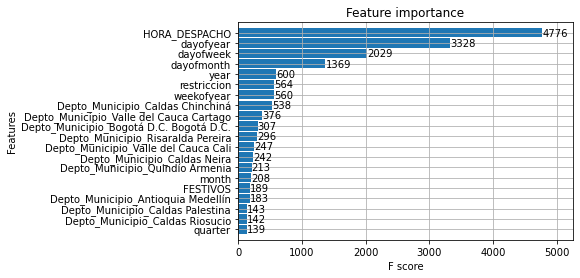

In [5]:
XGBoost_terminals('T.T. DE MANIZALES')